In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Домашнее задание по рекомендательным системам

В данном домашнем задании вам предлагается реализовать User-based рекомендательную систему. Так же требуется реализовать несколько вспомогательных функций, шаблоны которых вы можете найти в `utils.py`.

Требования к выполнению задания:
- Реализация функции из `utils.py` засчитывается, только если пройдены все соответствующие тесты из `test.py`. Запуск тестов: <font color='red'>pytest test.py</font>. Для тестов вам потребуются библиотеки `numpy`, `scipy`, `pytest` и `hypothesis`.
- Плагиат запрещен. Если будет замечено, что часть задания списана, то 0 баллов ставится как списывающему, так и давшему списать.
- Если пользуетесь кодом из открытых источников, то указывайте ссылки, откуда взяли решение. Иначе такой код может быть воспринят как плагиат.
- При выполнении задания нельзя использовать библиотеку `scipy` и функцию `numpy.linalg.norm`

При запуске тестов могут появиться предупреждения: PearsonRConstantInputWarning и PearsonRNearConstantInputWarning. На них можно не обращать внимания.

Возможный максимум баллов за задание: 10 баллов <br>
Дедлайн: ??? <br>
Штраф: ??? - будет ли в курсе штраф? <br>
<br>
Для ускорения проверки, напишите здесь получившееся количество баллов: ...

## 1. Метрика сходства
<b>1.1. Реализация метрик (2 балла)</b>

Первое, с чем необходимо разобраться, при реализации User-based подхода, это с метрикой, с помощью которой будет решаться, насколько похожи пользователи. Вам предлагается реализовать 2 метрики: на основе евклидовой метрики и коэффициент корреляции Пирсона. Шаблоны для обоих функций можете найти в `utils.py`. Не забудьте проверить реализацию на тестах.

Евклидова метрика:
\begin{equation}
d(p,q)=\sqrt{(p_1-q_1)^2+(p_2-q_2)^2+\dots+(p_n-q_n)^2} = \sqrt{\sum_{k=1}^n (p_k-q_k)^2}
\end{equation}

В этом случае $d(p, q) \in [0, \infty)$, при этом если $d(p, q) \to 0$, то $sim(p, q) \to 1$. С учетом этого конечная формула будет выглядеть следующим образом:
\begin{equation}
sim(p, q) = \frac{1}{1 + d(p, q)}
\end{equation}
Так же в этой формуле не будет проблем с делением на 0.

Коэффициент корреляции Пирсона:
\begin{equation}
r_{xy} = \frac {\sum_{i=1}^{m} \left( x_i-\bar{x} \right)\left( y_i-\bar{y} \right)}{\sqrt{\sum_{i=1}^{m} \left( x_i-\bar{x} \right)^2 \sum_{i=1}^{m} \left( y_i-\bar{y} \right)^2}}
\end{equation}

<b>1.2. (1 балл)</b>

Рассмотрим пользователей $u$ и $v$. Им соотвествуют векторы $x_u$ и $x_v$, где $x_u[i] = r_{ui}$ и $x_v[i] = r_{vi}$. Из лекции известно, что похожесть между векторами $x_u$ и $x_v$ вычисляются только для тех индексов i, для которых существует и $r_{ui}$, и $r_{vi}$. То есть верно следуюющее:
\begin{equation}
sim(u, v) = sim(x_uI_{uv}, x_vI_{uv}),
\end{equation}
где $I_{uv} = [i | \exists r_{ui} \& \exists r_{vi}]$. При этом если $I_{uv} = \emptyset$, то $sim(u, v) \to -\infty$.

Реализуйте два новых метода, которые переиспользуют написанные вами `euclidean_distance` и `pearson_distance`, добавляющие условия на $x_u$ и $x_v$. Считается, что $x_u[i] = 0$, если $\nexists r_{ui}$. То же верно для $x_v$.

При реализации заданий можно как написать новые функции, так и использовать декораторы.

Подключение модуля utils.

In [1]:
!ls /content/drive/My\ Drive/*.py

'/content/drive/My Drive/test.py'  '/content/drive/My Drive/utils.py'


In [ ]:
!cat "/content/drive/MyDrive/utils.py"

In [3]:
import sys
sys.path.append('/content/drive/My Drive')

Реализация новых функций.

In [5]:
import numpy as np
from utils import *

In [6]:
def euclidean_distance_cond(x: np.array, y: np.array) -> float:
  x_ = x[(x != 0) & (y != 0)]
  y_ = y[(x != 0) & (y != 0)]
  return euclidean_distance(x_, y_)

def euclidean_similarity_cond(x: np.array, y: np.array) -> float:
  return 1 / (1 + euclidean_distance_cond(x, y))

def pearson_similarity_cond(x: np.array, y: np.array) -> float:
  x_ = x[(x != 0) & (y != 0)]
  y_ = y[(x != 0) & (y != 0)]
  return pearson_similarity(x_, y_)

## 2. User-based method
<b>2.1. (3 балла)</b> 

Реализовать User-based подход, реализовав методы класса `UserBasedRecommendation`, основанного на использовании `NearestNeighbors`. В качестве метрики может для нахождения похожих пользователей может быть использована как евклидова метрика, так и коэффициент корреляции Пирсона.

Не забывайте, что `NearestNeighbors` ищет минимум расстояния между элементами, поэтому логично в качестве метрики при инициализации `NearestNeighbors` использовать обратную метрике схожести. То есть такую, что когда $sim(u, v) \to 1$, то $d(u, v) \to 0$. Например: $d(u, v) = 1 - sim(u, v)$

Реализация обратных метрик.

In [7]:
def inv_euclidean_similarity(x: np.array, y: np.array) -> float:
  return 1 - euclidean_similarity_cond(x, y)

def inv_pearson_similarity(x: np.array, y: np.array) -> float:
  return 1 - pearson_similarity_cond(x, y)

Реализация класса.

In [8]:
from sklearn.neighbors import NearestNeighbors
from typing import Optional

from collections import Counter


class UserBasedRecommendation:
    def __init__(self, metric: str = 'euclidean', n_recommendations: int = 5, alpha: float = 0.2):
        """
        Args:
            metric: name of metric: ['euclidean', 'pearson']
            n_recommendations: number of recommendations. Also can be specified self.make_recommendation
            alpha: similarity threshold: if sim(u, v) > alpha then u and v are similar
        """
        self.metric = metric
        self.n_recommendations = n_recommendations
        self.alpha = alpha

    def fit(self, X: np.array):
        """
        Args:
            X: matrix N x M where X[u, i] = r_{ui} if r_{ui} exists else X[u, i] = 0
        """
        self.X = X

    def __find_closest_users(self, user_id: int, n_closest_users: int):
        if self.metric == 'euclidean':
          neigh = NearestNeighbors(metric=inv_euclidean_similarity)
        elif self.metric == 'pearson':
          neigh = NearestNeighbors(metric=inv_pearson_similarity)
        neigh.fit(self.X)
        
        return neigh.kneighbors([self.X[user_id]], n_closest_users)

    def make_recommendation(self, user_id: int, n_recommendations: Optional[int] = 1, n_closest_users: Optional[int] = 1):
        """
        Args:
            user_id: user id to whom you want to recommend
            n_recommendations: number of recommendations
        """
        closest_users = self.__find_closest_users(user_id, n_closest_users + 1)
        closest_users = closest_users[1][0][1 - closest_users[0][0] > self.alpha] # отбираем по пороговой alpha
        closest_users = np.delete(closest_users, np.where(closest_users == user_id)) # удаляем из соседей исходный вектор

        rec_lst = []
        for j in range(self.X.shape[1]):
          if (closest_users.shape[0] != 0): 
            # т.к. оценка не бинарная (купил/не купил), то для p будем сумму оценок делить на кол-во соседей
            p = sum([self.X[i][j] for i in closest_users if self.X[i][j] != 0]) / closest_users.shape[0]
          else:
            p = 0
          rec_lst.append((p, j))
          
        rec_lst = sorted(rec_lst, key=lambda x: -x[0])

        return list(map(lambda x: x[1], rec_lst[:n_recommendations]))

<b>2.2. (1 балла)</b>

Приведите пример, для которого использование разных метрик будет давать разные рекомендации. Объясните свой пример.

In [9]:
data = np.array([
          [1.4,   1.1],
          [0.9,   0.75],
          [0.4, 0.5],
])

In [16]:
recsys = UserBasedRecommendation(alpha=0.6)
recsys.fit(data)
recsys.make_recommendation(1, n_recommendations=1, n_closest_users=1)

[1]

In [17]:
recsys = UserBasedRecommendation('pearson', alpha=0.8)
recsys.fit(data)
recsys.make_recommendation(1, n_recommendations=1, n_closest_users=1)

[0]

**Объяснение:**

Нам дана таблица из 3 строк (пользователи) и 2 столбцов (товары). Как видно, хотя оценки пользователей 1 и 2 различаются, оба оценили товар 1 выше, чем товар 2. Пользователь 3 оценил оба товара намного ниже, и товар 1 ему понравился меньше, чем товар 2.

Делаем рекомендацию для пользователя 2:


*   Евклидова метрика: сосед - пользователь 3 (разница в оценках чуть меньше, чем с пользователем 2, корреляция в оценках не учитывается), значит рекомендация - товар 2.
*   Критерий Пирсона: сосед - пользователь 1 (учитывается корреляция в оценках), значит рекомендация - товар 1.



## 3. Оценка качества
<b>3.1. (1 балл)</b>

Реализуйте Average Precision at k и Mean Average Precision at k. Шаблоны можете найти в `utils.py`.
\begin{align*}
AP@K = \frac{1}{m}\sum_{k=1}^K P(k)*rel(k), \\
MAP@K = \frac{1}{|U|}\sum_{u=1}^{|U|}(AP@K)_u
\end{align*}
где $P(k)$ - Precision at k, $rel(k) = 1$, если рекомендация релевантна, иначе $rel(k) = 0$.

**Ответ:** функции реализованы в `utils`, ранее были импортированы.

## 4. Применение модели
<b>4.1. (2 балла)</b>

Выгрузите датасет `ratings_small.csv`: https://www.kaggle.com/rounakbanik/the-movies-dataset#ratings_small.csv

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [19]:
data = pd.read_csv('/content/drive/MyDrive/Тинькофф.Поколение/ratings_small.csv', index_col=False)
data.shape

(100004, 4)

In [20]:
data.userId.min(), data.userId.max(), len(data.userId.unique())

(1, 671, 671)

In [21]:
data.movieId.min(), data.movieId.max(), len(data.movieId.unique())

(1, 163949, 9066)

In [22]:
data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Для простоты работы с данными, измените нумерацию пользователей и фильмов так, чтобы нумерация начиналась с 0 и шла непрерывно.

In [23]:
user_ids = np.unique(data['userId']) # с помощью словарей изменяем нумерацию данных
user_dict = {user_ids[i]: i for i in range(user_ids.shape[0])}

movie_ids = np.unique(data['movieId'])
movie_dict = {movie_ids[i]: i for i in range(movie_ids.shape[0])}

data['userId'] = data['userId'].apply(lambda x: user_dict[x])
data['movieId'] = data['movieId'].apply(lambda x: movie_dict[x])

In [24]:
data.userId.min(), data.userId.max(), len(data.userId.unique())

(0, 670, 671)

In [25]:
data.movieId.min(), data.movieId.max(), len(data.movieId.unique())

(0, 9065, 9066)

Удалим для наиболее активных пользователей 5 оценок

In [26]:
active_users = data.userId.value_counts()[:10].index
test_data = pd.DataFrame([], columns=data.columns)
for user_id in active_users:
    _, test = train_test_split(data[data.userId == user_id], test_size=5, random_state=42)
    test_data = test_data.append(test, ignore_index=True)
    data = data[~((data.userId == user_id) & (data.movieId.isin(test.movieId.values)))]
data.shape, test_data.shape

((99954, 4), (50, 4))

Преобразуем данные в таблицу `X`, с которой может работать `UserBasedRecommendation`, где $X_{ui} = r_{ui}$, если пользователь $u$ поставил оценку фильму $i$, и $X_{ui} = 0$, если пользователь $u$ не проставил оценку фильму $i$.

Вам может пригодиться `csr_matrix`.

In [27]:
import scipy.sparse as scp # FROM INCLASS

def get_sparse(data):
    return scp.coo_matrix(
        (
            data['rating'],
            (data['userId'], data['movieId'])
        ), 
        shape=(len(user_dict), len(movie_dict))
    ).tocsr()

In [28]:
X = get_sparse(data)

Для пользователей, у которых были удалены фильмы, найдите топ 100 фильмов, который должен посмотреть каждый из этих пользователей, используя `UserBasedRecommendation`. Не забудьте подобрать параметр alpha.

Используя метрику `MAP@5`, `MAP@10` и `MAP@100`, определите, насколько эффективна user-based рекомендательная система для данной задачи.

In [31]:
def get_movies(user, k): # предоставлено Кириллом в чате ML)
    db = data[data.userId == user]
    db = sorted(list(db.iterrows()), key=lambda x: -x[1].rating)
    return list(map(lambda x: x[1].movieId, db))[:k]

In [32]:
actual_lst = np.array([get_movies(i, 100) for i in active_users]) # получаем тестовые данные

Подберем оптимальное alpha для метрики - `'euclidean'`, нарисуем график для наглядности.

In [33]:
mapk5 = []
mapk10 = []
mapk100 = []

for alpha in np.arange(0, 1, 0.05):
  recsys = UserBasedRecommendation(alpha=alpha)
  recsys.fit(X.toarray())
  res_lst = []
  for i in active_users:
    res = recsys.make_recommendation(i, 100, 10)
    res_lst.append(res)

  res_lst = np.array(res_lst)
  mapk5.append(mapk(actual_lst[:, :5], res_lst[:, :5], 5))
  mapk10.append(mapk(actual_lst[:, :10], res_lst[:, :10], 10))
  mapk100.append(mapk(actual_lst, res_lst, 100))

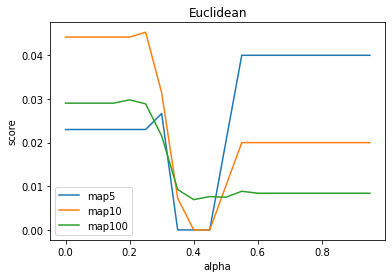

In [34]:
from matplotlib import pyplot as plt

plt.plot(np.arange(0, 1, 0.05), mapk5, label='map5')
plt.plot(np.arange(0, 1, 0.05), mapk10, label='map10')
plt.plot(np.arange(0, 1, 0.05), mapk100, label='map100')
plt.title('Euclidean')
plt.xlabel('alpha')
plt.ylabel('score')
plt.legend()
plt.show()

Подберем оптимальное alpha для метрики - `'pearson'`, нарисуем график для наглядности.

In [ ]:
mapk5 = []
mapk10 = []
mapk100 = []

for alpha in np.arange(0, 1, 0.05):
  recsys = UserBasedRecommendation('pearson', alpha=alpha)
  recsys.fit(X.toarray())
  res_lst = []
  for i in active_users:
    res = recsys.make_recommendation(i, 100, 10)
    res_lst.append(res)

  res_lst = np.array(res_lst)
  mapk5.append(mapk(actual_lst[:, :5], res_lst[:, :5], 5))
  mapk10.append(mapk(actual_lst[:, :10], res_lst[:, :10], 10))
  mapk100.append(mapk(actual_lst, res_lst, 100))

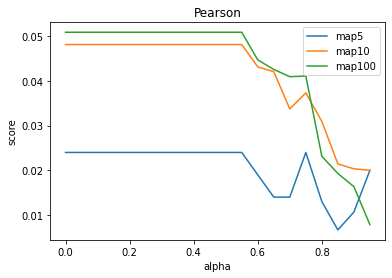

In [36]:
plt.plot(np.arange(0, 1, 0.05), mapk5, label='map5')
plt.plot(np.arange(0, 1, 0.05), mapk10, label='map10')
plt.plot(np.arange(0, 1, 0.05), mapk100, label='map100')
plt.title('Pearson')
plt.xlabel('alpha')
plt.ylabel('score')
plt.legend()
plt.show()

Метрика `'pearson'` показывает более высокий скор, при этом можем взять для нее удобное `alpha=0.5` (при более высоком `alpha` скор падает).

На лучшей модели (`metric='pearson'`, `alpha=0.5`) найдем оптимальное количество соседей для пользователя (это не окончательное количество, ведь потом мы не рассматриваем соседей, для которых `similarity<=alpha`).

In [ ]:
mapk5 = []
mapk10 = []
mapk100 = []

for n in [1, 10, 20, 50, 100, 200, 300, 500]:
  recsys = UserBasedRecommendation('pearson', alpha=0.5)
  recsys.fit(X.toarray())
  res_lst = []
  for i in active_users:
    res = recsys.make_recommendation(i, 100, n)
    res_lst.append(res)

  res_lst = np.array(res_lst)
  mapk5.append(mapk(actual_lst[:, :5], res_lst[:, :5], 5))
  mapk10.append(mapk(actual_lst[:, :10], res_lst[:, :10], 10))
  mapk100.append(mapk(actual_lst, res_lst, 100))

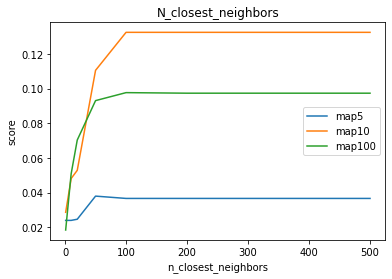

In [38]:
plt.plot([1, 10, 20, 50, 100, 200, 300, 500], mapk5, label='map5')
plt.plot([1, 10, 20, 50, 100, 200, 300, 500], mapk10, label='map10')
plt.plot([1, 10, 20, 50, 100, 200, 300, 500], mapk100, label='map100')
plt.title('N_closest_neighbors')
plt.xlabel('n_closest_neighbors')
plt.ylabel('score')
plt.legend()
plt.show()

При `n_closest_neighbors>100` качество ранжирования не изменяется и является лучшим результатом (при более низких `n_closest_neighbors` качество падает).

**Лучшая модель:**


*   `metric='pearson'`,
*   `alpha=0.5`,
*   `n_closest_neighbors=100`.


In [ ]:
recsys = UserBasedRecommendation('pearson', alpha=0.5)
recsys.fit(X.toarray())
res_lst = []
for i in active_users:
  res = recsys.make_recommendation(i, 100, 100)
  res_lst.append(res)

res_lst = np.array(res_lst)

**Лучший результат:**

In [42]:
print('MAP@5: ', mapk(actual_lst[:, :5], res_lst[:, :5], 5))
print('MAP@10: ', mapk(actual_lst[:, :10], res_lst[:, :10], 10))
print('MAP@100: ', mapk(actual_lst, res_lst, 100))

MAP@5:  0.03666666666666667
MAP@10:  0.13246031746031744
MAP@100:  0.09768482146121783


MAP@5:  0.03666666666666667

MAP@10:  0.13246031746031744

MAP@100:  0.09768482146121783

Как можно улучшить работу модели?

<b>Ответ:</b>

1. Попробовать другие метрики схожести пользователей:
  * Корреляция Спирмана,
  * Косинусное расстояние

2. Нормализовать данные (например, оценки пользователя для любого фильма не превышают 5 по 10-балльной шкале):
  * Центрирование,
  * Стандартизация,
  * Двойная Стандартизация

3. Доступные свойства пользователей/товаров позволят значительно повысить качество подбора "соседей",

4. Возможно, item-based или гибридная система была бы более пригодна для данной задачи.